<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/02_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Attention

As we know, There are two sequences now: the source and the target. We use the
former to predict the latter, and they may even have different lengths.

A typical example of a sequence-to-sequence problem is translation: A sentence
goes in (a sequence of words in English), and another sentence comes out (a
sequence of words in French). This problem can be tackled using an encoderdecoder
architecture.



We’ll start by generating a synthetic dataset and then use it to
illustrate the inner workings of:

1. encoder-decoder architecture,
2. models to predict a target sequence from a source sequence,
3. attention mechanisms, and
4. multi-headed attention mechanism



##Setup

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter9()
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *

Finished!


In [2]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

from data_generation.square_sequences import generate_sequences
from stepbystep.v4 import StepByStep

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset

We’ll keep drawing the same squares as before, but this time we’ll draw the first
two corners ourselves (the source sequence) and ask our model to predict the
next two corners (the target sequence).

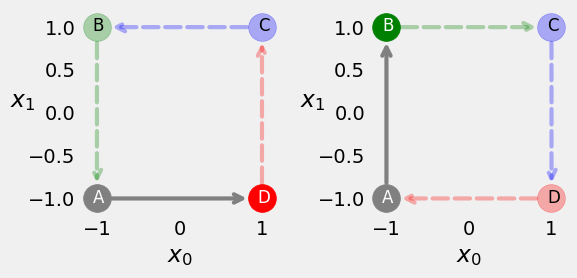

In [4]:
fig = counter_vs_clock(binary=False)

Since there are four corners to start from and two directions to follow, there are
effectively eight possible sequences (solid colors indicate the corners in the source
sequence, semi-transparent colors, the target sequence).

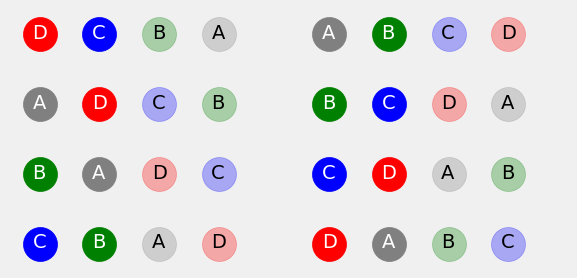

In [5]:
fig = plot_sequences(binary=False, target_len=2)

Since the desired output of our model is a sequence of coordinates (x0, x1), we’re
dealing with a regression problem now.

Therefore, we’ll be using a typical mean
squared error loss to compare the predicted and actual coordinates for the two
points in the target sequence.

Let’s generate 256 random noisy squares.

In [6]:
points, directions = generate_sequences(n=256, seed=13)

And then let’s visualize the first five squares.

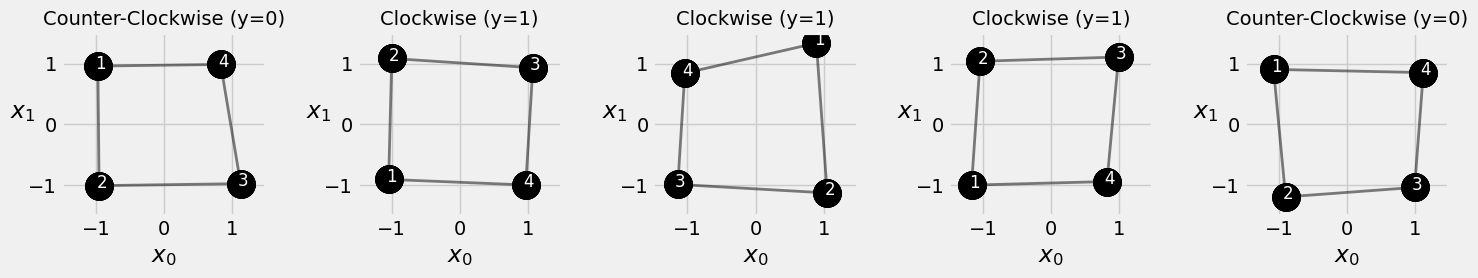

In [7]:
fig = plot_data(points, directions, n_rows=1)

##Encoder-Decoder

In order to output a sequence we need a more complex architecture.

The encoder-decoder is a combination of two models: the encoder and the
decoder.

The encoder’s goal is to generate a representation of the source
sequence; that is, to encode it.

It is a typical recurrent neural network that
we’re using to encode the source sequence.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/encoder.png?raw=1)

The encoder model simply
returns a sequence of hidden states.

###Encoder

In [8]:
class Encoder(nn.Module):
  def __init__(self, n_features, hidden_dim):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.n_features = n_features
    self.hidden = None
    self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)

  def forward(self, X):
    rnn_out, self.hidden = self.basic_rnn(X)
    return rnn_out  # N, L, F

Don’t we need only the final hidden state?

That’s correct. We’ll be using the final hidden state only but in the "Attention", we’ll be using all hidden states, and
that’s why we’re implementing the encoder.

Let’s go over a simple example of encoding: We start with a sequence of coordinates of a "perfect" square and split it into source and target sequences:

In [9]:
full_seq = (torch.tensor([
  [-1, -1],
  [-1, 1],
  [1, 1],
  [1, -1]
]).float().view(1, 4, 2))
full_seq

tensor([[[-1., -1.],
         [-1.,  1.],
         [ 1.,  1.],
         [ 1., -1.]]])

In [10]:
source_seq = full_seq[:, :2]  # first two corners
target_seq = full_seq[:, 2:]  # last two corners

Now, let’s encode the source sequence and take the final hidden state.

In [11]:
torch.manual_seed(21)

encoder = Encoder(n_features=2, hidden_dim=2)

# output is N, L, F
hidden_seq = encoder(source_seq)
# takes last hidden state
hidden_final = hidden_seq[:, -1:]
hidden_final

tensor([[[ 0.3105, -0.5263]]], grad_fn=<SliceBackward0>)

Of course, the model is untrained, so the final hidden state above is totally random.

In a trained model, however, the final hidden state will encode information about
the source sequence.



###Decoder

The decoder’s goal is to generate the target sequence from an
initial representation; that is, to decode it.

Sounds like a perfect match, doesn’t it?

Encode the source sequence, get its
representation (final hidden state), and feed it to the decoder so it generates the
target sequence.

How does the decoder transform a hidden state into a sequence?

We can use recurrent layers for that as well.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/decoder.png?raw=1)

* In the first step, the initial hidden state is the encoder’s final hidden state ($h_f$, in blue).
* The first cell will output a new hidden state ($h_2$): That’s both the output of that cell and one of the inputs of the next cell.
* Before, we’d only run the final hidden state through a linear layer to produce the logits, but now we’ll run the output of every cell through a linear layer ($w^Th$) to convert each hidden state into predicted coordinates ($x_2$).
* The predicted coordinates are then used as one of the inputs of the second
step ($x_2$).

The first cell takes both an initial hidden state ($h_f$, in blue, the
encoder’s output) and a first data point ($x_1$, in red).

In our case, the decoder’s first data point is actually the last data point in the
source sequence because the target sequence is not a new sequence, but the
continuation of the source sequence.

This is not always the case. In translation, where the target sequence is a new sequence, the first data point is
some "special" token that indicates the start of that new sequence.

There is another small, yet fundamental difference between the
encoder and the decoder: Since the decoder uses the prediction
of last step as input to the next, we’ll have to manually loop over
the generation of the target sequence.

This also means we need to keep track of the hidden state from
last step to the next, using the hidden state of last step as input
to the next.

But, instead of making the hidden state both an input and an
output of the `forward()` method, we can easily handle this by making the hidden state an
attribute of our decoder model.




In [12]:
class Decoder(nn.Module):

  def __init__(self, n_features, hidden_dim):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.n_features = n_features
    self.hidden_state = None

    # Simple RNN
    self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
    # regression to produce a logits as outputs
    self.regression = nn.Linear(self.hidden_dim, self.n_features)

  def init_hidden(self, hidden_seq):
    # We only need the final hidden state
    hidden_final = hidden_seq[:, -1:]  # N, 1, H
    # Initializing decoder’s hidden state using encoder’s final hidden state.
    self.hidden_state = hidden_final.permute(1, 0, 2) # But we need to make it sequence-first

  def forward(self, X):
    # X is batch first (N, L, F)
    # The recurrent layer both uses and updates the hidden state
    batch_first_output, self.hidden_state = self.basic_rnn(X, self.hidden_state)

    last_output = batch_first_output[:, -1:]
    out = self.regression(last_output)

    # The output has the same shape as the input (N, 1, F)
    return out.view(-1, 1, self.n_features)

So it’s time
to try some decoding to generate a target sequence:

In [13]:
torch.manual_seed(21)

decoder = Decoder(n_features=2, hidden_dim=2)

# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
  print(f"Hidden: {decoder.hidden_state}")
  # Predicts coordinates
  outputs = decoder(inputs)
  print(f"Output: {outputs}\n")
  # Predicted coordinates are next step's inputs
  inputs = outputs

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[0.3205, 0.1144]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.8898, -0.3653]]], grad_fn=<StackBackward0>)
Output: tensor([[[0.2905, 0.1976]]], grad_fn=<ViewBackward0>)



There is one problem with the approach above, though—an untrained model will
make really bad predictions, and these predictions will still be used as inputs for
subsequent steps.

This makes model training unnecessarily hard because the
prediction error in one step is caused by both the (untrained) model and the
prediction error in the previous step.

Can’t we use the actual target sequence instead?

Sure we can! This technique is called teacher forcing.

###Teacher Forcing

The reasoning is simple: Ignore the predictions and use the real data from the
target sequence instead.

In [14]:
# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
  print(f"Hidden: {decoder.hidden_state}")
  # Predicts coordinates
  outputs = decoder(inputs)
  print(f"Output: {outputs}\n")
  # But completely ignores the predictions and uses real data instead
  inputs = target_seq[:, i: i + 1]  # Inputs to the next step are not predictions anymore

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[0.3205, 0.1144]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.8898, -0.3653]]], grad_fn=<StackBackward0>)
Output: tensor([[[0.2230, 0.4052]]], grad_fn=<ViewBackward0>)



This is great for training time, sure—but what about testing time,
when the target sequence is unknown?

At testing time, there is no escape from using only the model’s own predictions
from previous steps.

The problem is, a model trained using teacher forcing will minimize the loss given
the correct inputs at every step of the target sequence. But, since this will never
be the case at testing time, the model is likely to perform poorly when using its
own predictions as inputs.

What can we do about it?

During training, sometimes the model will use
teacher forcing, and sometimes it will use its own predictions.

So we occasionally
help the model by providing an actual input, but we still force it to be robust
enough to generate and use its own inputs.

In [15]:
# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

teacher_forcing_prob = 0.5
target_len = 2
for i in range(target_len):
  print(f"Hidden: {decoder.hidden_state}")
  # Predicts coordinates
  outputs = decoder(inputs)
  print(f"Output: {outputs}\n")
  # If it is teacher forcing
  if torch.rand(1) <= teacher_forcing_prob:
    # Takes the actual element
    inputs = target_seq[:, i: i + 1]  # Inputs to the next step are not predictions anymore
  else:
    # Otherwise uses the last predicted output
    inputs = outputs

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[0.3205, 0.1144]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.8898, -0.3653]]], grad_fn=<StackBackward0>)
Output: tensor([[[0.2230, 0.4052]]], grad_fn=<ViewBackward0>)



###Encoder + Decoder

Now it is time to put the two of them together…

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/encoder_decoder.png?raw=1)

Let’s go over it once again:

* The encoder receives the source sequence ($x_0$ and $x_1$, in red) and generates the representation of the source sequence, its final hidden state ($h_f$, in blue).
* The decoder receives the hidden state from the encoder ($h_f$, in blue), together with the last known element of the sequence ($x_1$, in red), to output a hidden state ($h_2$, in green) that is converted into the first set of predicted coordinates($x_2$, in green) using a linear layer ($w^Th$, in green).
* In the next iteration of the loop, the model randomly uses the predicted ($x_2$, in green) or the actual ($x_2$, in red) set of coordinates as one of its inputs to output the second set of predicted coordinates ($x_3$), thus achieving the target length.
* The final output of the encoder + decoder model is the full sequence of
predicted coordinates: [$x_2$, $x_3$].

We can assemble the bits and pieces we’ve developed so far into a model that,
given the encoder and decoder models, implements a `forward()` method that splits
the input into the source and target sequences, loops over the generation of the
target sequence, and implements teacher forcing in training mode.

In [16]:
class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.input_len = input_len
    self.target_len = target_len
    self.teacher_forcing_prob = teacher_forcing_prob
    self.outputs = None

  def init_outputs(self, batch_size):
    device = next(self.parameters()).device
    # N, L (target), F
    self.outputs = torch.zeros(batch_size,
                               self.target_len,
                               self.encoder.n_features).to(device)

  def store_output(self, idx, output):
    # Stores the output
    self.outputs[:, idx: idx + 1, :] = output

  def forward(self, X):
    # splits the data in source and target sequences
    # the target seq will be empty in testing mode
    # N, L, F
    source_seq = X[:, : self.input_len, :]
    target_seq = X[:, self.input_len:, :]
    self.init_outputs(X.shape[0])

    # Encoder expected N, L, F
    hidden_seq = self.encoder(source_seq)
    # Output is N, L, H
    self.decoder.init_hidden(hidden_seq)

    # The last input of the encoder is also the first input of the decoder
    decoder_inputs = source_seq[:, -1:, :]

    # Generates as many outputs as the target length
    for i in range(self.target_len):
      # Output of decoder is N, 1, F
      output = self.decoder(decoder_inputs)
      self.store_output(i, output)

      prob = self.teacher_forcing_prob
      # In evaluation/test the target sequence is unknown, so we cannot use teacher forcing
      if not self.training:
        prob = 0

      # If it is teacher forcing
      if torch.rand(1) <= prob:
        # Takes the actual element
        decoder_inputs = target_seq[:, i: i + 1, :]
      else:
        # Otherwise uses the last predicted output
        decoder_inputs = output

    return self.outputs

Let’s create an instance of the model.

In [17]:
encoder_decoder = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)

In training mode, the model expects the full sequence so it can randomly use
teacher forcing:

In [18]:
encoder_decoder.train()
encoder_decoder(full_seq)

tensor([[[0.3205, 0.1144],
         [0.2905, 0.1976]]], grad_fn=<CopySlices>)

In evaluation / test mode, though, it only needs the source sequence as input:

In [19]:
encoder_decoder.eval()
encoder_decoder(source_seq)

tensor([[[0.3205, 0.1144],
         [0.2905, 0.1976]]], grad_fn=<CopySlices>)

###Data Preparation

For the training set, we need the full sequences as features (X) to use teacher
forcing, and the target sequences as labels (y) so we can compute the mean
squared error loss.

In [20]:
points, directions = generate_sequences(n=256, seed=19)

full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

<ipython-input-20-342fc738025a>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  full_train = torch.as_tensor(points).float()


For the test set, though, we only need the source sequences as features (X) and the
target sequences as labels (y):

In [21]:
test_points, test_directions = generate_sequences(seed=19)

full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

These are all simple tensors, so we can use TensorDatasets and simple data
loaders.

In [22]:
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

###Model Training

In [23]:
torch.manual_seed(23)

encoder = Encoder(n_features=2, hidden_dim=2)
decoder = Decoder(n_features=2, hidden_dim=2)
model = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)

loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [24]:
sbs_seq = StepByStep(model, loss, optimizer)
sbs_seq.set_loaders(train_loader, test_loader)
sbs_seq.train(100)

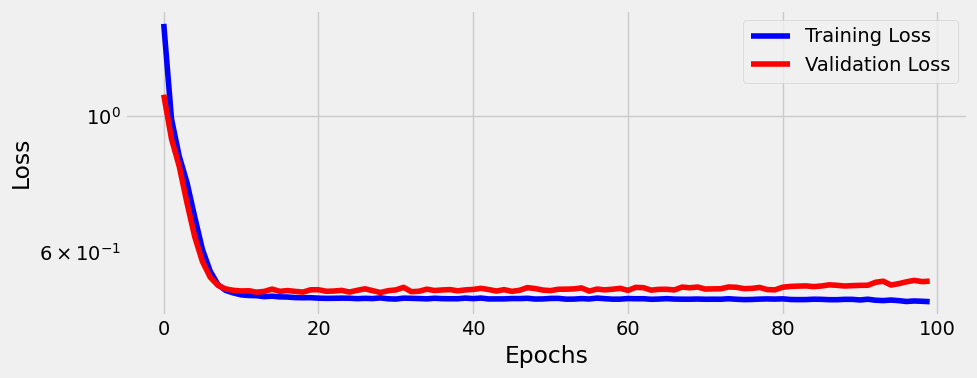

In [25]:
fig = sbs_seq.plot_losses()

###Visualizing Predictions

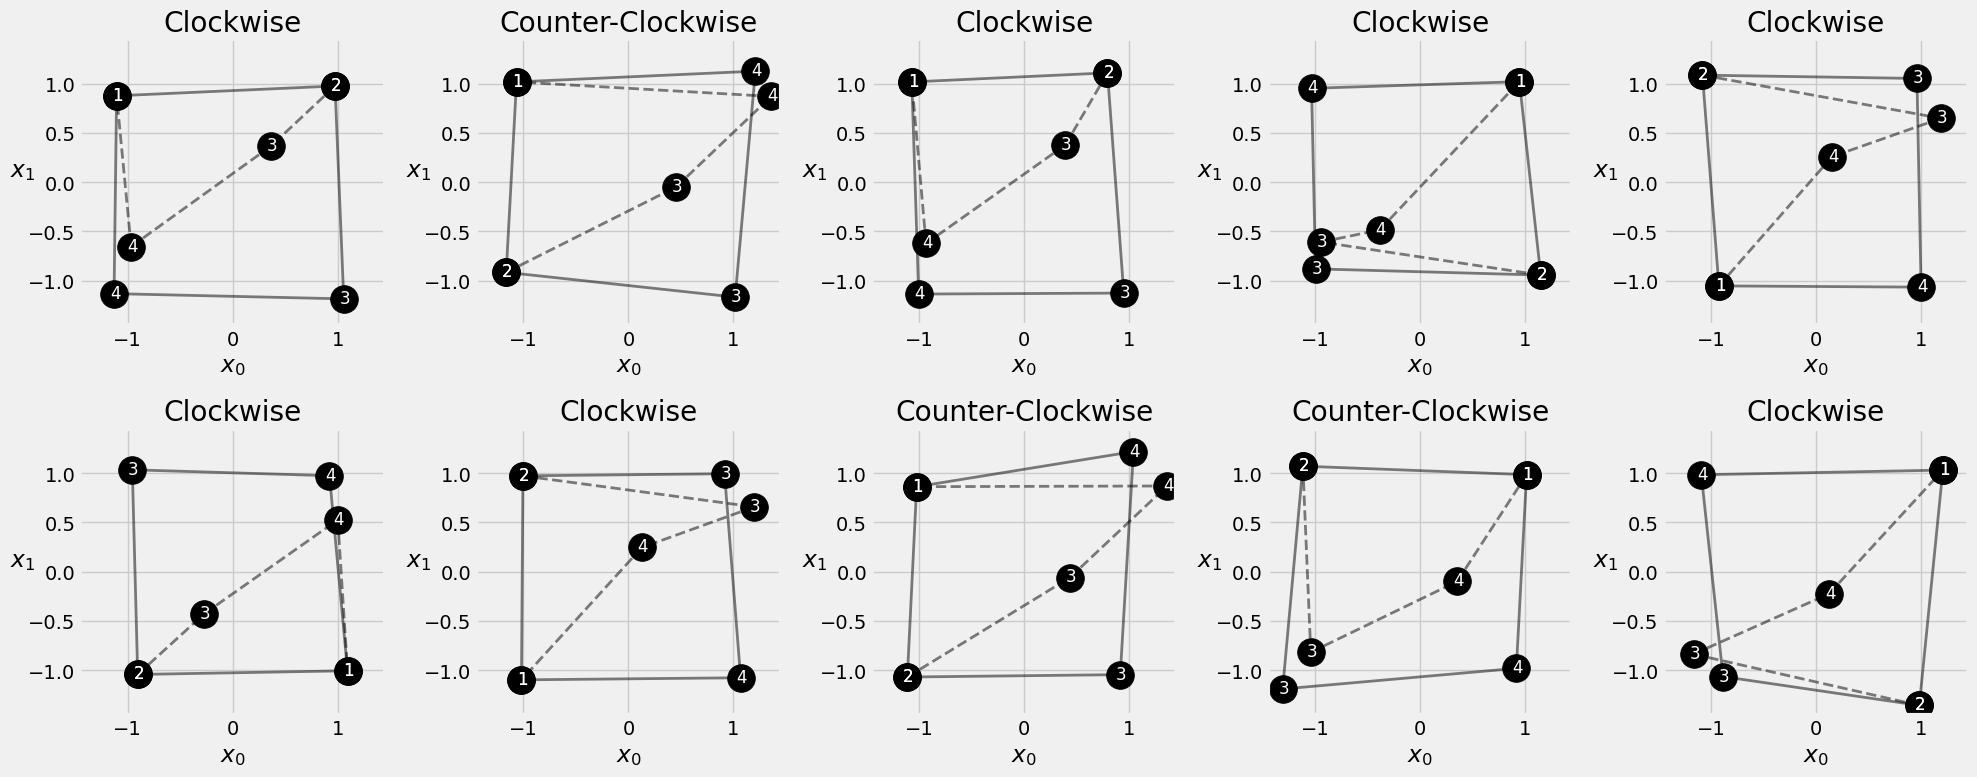

In [26]:
fig = sequence_pred(sbs_seq, full_test, test_directions)

The encoder-decoder architecture is really interesting, but it has a bottleneck: The
whole source sequence gets to be represented by a single hidden state, the final
hidden state of the encoder part.

Even for a very short source sequence like ours,
it’s quite a big ask to have the decoder generate the target sequence with so little
information.

Can we make the decoder use more information?

##Attention

What if the decoder could choose one (or more) of the encoder’s hidden states to use instead of being forced to stick with only the final one?

That would surely give it more flexibility to use the hidden state that’s more
useful at a given step of the target-sequence generation.

In other words, we can say that the decoder is paying attention
to different elements in the source sequence. That’s the famous
attention mechanism in a nutshell.

Let’s take an example of English and French sentence and build a matrix with English words (the source sequence) as columns and French words (the target sequence) as rows.

The entries in this matrix represent our guesses of how much attention the decoder is paying to each English word in order to generate a given French word.

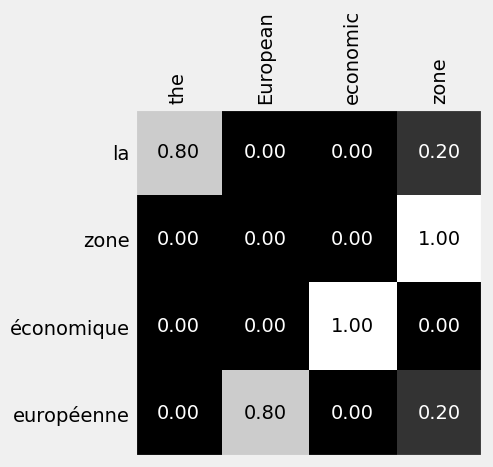

In [27]:
fig = figure9()

These weights are the attention scores.

The more relevant to the decoder a hidden state from the
encoder is, the higher the score.

OK, I get what the attention scores represent, but how does the
decoder actually use them?

If you notice, the attention scores actually add up to one, so they will
be used to compute a weighted average of the encoder’s hidden states.

To keep it short and simple, So we’re translating two words only, from "the zone" in English to "la zone" in French.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/enc_dec_attn_translate.png?raw=1)


The main difference is, instead of generating predictions solely based on its own hidden states, the decoder will recruit the attention mechanism to help it decide which parts of the source sequence it must pay attention to.

In our made-up example, the attention mechanism informed the decoder it should
pay 80% of its attention to the encoder’s hidden state corresponding to the word "the," and the remaining 20% to the word "zone."

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/context_translate.png?raw=1)



###Values

Let's refer to the encoder’s hidden states (or their affine
transformations) as "values" (V). The resulting multiplication of a "value" by its corresponding attention score is called an alignment vector.

And the sum of all alignment vectors (that is, the weighted average of the
hidden states) is called a context vector.

$$
\large
\text{context vector} = \underbrace{\alpha_0 * h_0}_{\text{alignment vector}_0} + \underbrace{\alpha_1 * h_1}_{\text{alignment vector}_1} = 0.8 * \text{value}_{the} + 0.2 *\text{value}_{zone}
$$

OK, but where do the attention scores come from?

###Keys and Queries

The attention scores are based on matching each hidden state of the decoder ($h_2$) to every hidden state of the encoder ($h_0$ and $h_1$).

Some of them will be good matches (high attention scores) while some others will be poor matches (low attention scores).

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/kq_matches.png?raw=1)

The encoder’s hidden states are called "keys" ($K$), while the
decoder’s hidden state is called a "query" ($Q$).

The encoder’s hidden states are used as both "keys" ($K$) and "values" ($V$). And, we apply affine transformations to the hidden states, one for the "keys" another for the "values" so they will actually have different values.

Well, the general idea is that the encoder works like a key-value store, as if it were some sort of database, and then the decoder queries it. The attention mechanism looks the query up in its keys (the matching part) and returns its values.

The "query" ($Q$) is matched to both "keys" ($K$) to compute the attention scores (s) used to compute the context vector, which is simply the weighted average of the "values" ($V$).

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/score_alignment_translate.png?raw=1)

###Context Vector

Let’s go over a simple example using our own sequence-to-sequence
problem, and the "perfect" square as input.

In [28]:
full_seq = (torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2))

source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

The source sequence is the input of the encoder, and the hidden states it outputs are going to be both "values" ($V$) and "keys" ($K$):

In [29]:
torch.manual_seed(21)

encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq)  # encoder output

values = hidden_seq  # N, L, H
values

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [30]:
keys = hidden_seq  # N, L, H
keys

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

The encoder-decoder dynamics stay exactly the same: We still use the encoder’s
final hidden state as the decoder’s initial hidden state (even though we’re sending
the whole sequence to the decoder, it still uses the last hidden state only), and we
still use the last element of the source sequence as input to the first step of the
decoder:

In [31]:
torch.manual_seed(21)

decoder = Decoder(n_features=2, hidden_dim=2)
decoder.init_hidden(hidden_seq) # encoder output as decoder’s initial hidden state

# last element of the source sequence as input to the first step of the decoder
inputs = source_seq[:, -1:]
output = decoder(inputs)

The first "query" ($Q$) is the decoder’s hidden state (remember, hidden states are always sequence-first, so we’re permuting it to batch-first):

In [32]:
query = decoder.hidden_state.permute(1, 0, 2)  # N, 1, H
query

tensor([[[ 0.8898, -0.3653]]], grad_fn=<PermuteBackward0>)

OK, we have the "keys" and a "query," so let’s pretend we can compute attention scores (alphas) using them:

In [33]:
def calculate_alphas(key, query):
  N, L, H = key.size()
  alphas = torch.ones(N, 1, L).float() * 1 / L
  return alphas

In [34]:
alphas = calculate_alphas(keys, query)
alphas

tensor([[[0.5000, 0.5000]]])

We had to make sure scores had the right shape (N, 1, L) so that, when multiplied by the "values" with shape (N, L, H), it will result in a weighted sum of the alignment vectors with shape (N, 1, H).

$$
\Large
(\color{green}{N}\color{black}, 1, \color{red}{L}\color{black}) \times
(\color{green}{N}\color{black}, \color{red}{L}\color{black}, H) =
(\color{green}{N}\color{black}, 1\color{black}, H)
$$

In other words, we can simply ignore the first dimension, and PyTorch will go over
all the elements in the mini-batch for us:

In [35]:
# (N, 1, L) x (N, L, H) -> (1, L) x (L, H) -> (1, H)
context_vector = torch.bmm(alphas, values)
context_vector

tensor([[[ 0.1968, -0.2809]]], grad_fn=<BmmBackward0>)

Once the context vector is ready, we can concatenate it to the "query" (the
decoder’s hidden state) and use it as the input for the linear layer that actually
generates the predicted coordinates:

In [36]:
concatenated = torch.cat([context_vector, query], axis=-1)
concatenated

tensor([[[ 0.1968, -0.2809,  0.8898, -0.3653]]], grad_fn=<CatBackward0>)

The diagram below illustrates the whole thing: encoder, decoder, and attention
mechanism.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/encdec_attn.png?raw=1)

Yes, the scoring method will use the transformed "keys" and "queries" to compute the attention scores.

###Scoring Method

Let’s understand how the scoring method transforms a good match
between a "query" and a "key" into an attention score.

